In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass_v2\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, googlenet):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.googlenet_fe = nn.Sequential(*list(googlenet.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        #self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.googlenet_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(googlenet = models.googlenet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 5604004


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


train loss:  0.14245391162959012
Val loss:  0.13975815410199371
train accuracy:  0.4632495164410058
Val accuracy:  0.5391304347826087
Best model at the moment with Val_acc 53.91, saving...
Current time: 1.138 minutes. Time expected till completion: 112.673 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.12976227634418863
Val loss:  0.1346144779868748
train accuracy:  0.5589941972920697
Val accuracy:  0.5565217391304348
Best model at the moment with Val_acc 55.65, saving...
Current time: 2.022 minutes. Time expected till completion: 99.073 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


train loss:  0.12423486180416159
Val loss:  0.12695341835851254
train accuracy:  0.5880077369439072
Val accuracy:  0.5652173913043478
Best model at the moment with Val_acc 56.52, saving...
Current time: 2.901 minutes. Time expected till completion: 93.806 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.11911430972226583
Val loss:  0.12373952606449956
train accuracy:  0.5996131528046421
Val accuracy:  0.5739130434782609
Best model at the moment with Val_acc 57.39, saving...
Current time: 3.780 minutes. Time expected till completion: 90.716 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:02<00:00,  7.00it/s]


train loss:  0.11740475737379874
Val loss:  0.12105830130369767
train accuracy:  0.5986460348162476
Val accuracy:  0.5652173913043478
Current time: 4.650 minutes. Time expected till completion: 88.355 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


train loss:  0.11454862333128023
Val loss:  0.11985500895458719
train accuracy:  0.6121856866537717
Val accuracy:  0.5739130434782609
Current time: 5.526 minutes. Time expected till completion: 86.576 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


train loss:  0.1120463271897351
Val loss:  0.11741056494090868
train accuracy:  0.6141199226305609
Val accuracy:  0.5652173913043478
Current time: 6.396 minutes. Time expected till completion: 84.975 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.11193263666196303
Val loss:  0.11780164086300393
train accuracy:  0.6063829787234043
Val accuracy:  0.5565217391304348
Current time: 7.268 minutes. Time expected till completion: 83.580 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.11128387512275283
Val loss:  0.11298167031744252
train accuracy:  0.625725338491296
Val accuracy:  0.5739130434782609
Current time: 8.141 minutes. Time expected till completion: 82.310 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:02<00:00,  7.00it/s]


train loss:  0.10917623652365037
Val loss:  0.1127993194953255
train accuracy:  0.6150870406189555
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 9.014 minutes. Time expected till completion: 81.126 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


train loss:  0.10828854279084639
Val loss:  0.10991929665855739
train accuracy:  0.6179883945841392
Val accuracy:  0.5826086956521739
Current time: 9.887 minutes. Time expected till completion: 79.999 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


train loss:  0.10645314834911081
Val loss:  0.1106216197428496
train accuracy:  0.6237911025145068
Val accuracy:  0.6
Best model at the moment with Val_acc 60.0, saving...
Current time: 10.763 minutes. Time expected till completion: 78.929 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:02<00:00,  7.16it/s]


train loss:  0.10519872464571055
Val loss:  0.11241124453751937
train accuracy:  0.6421663442940039
Val accuracy:  0.5739130434782609
Current time: 11.632 minutes. Time expected till completion: 77.842 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.10358839281753598
Val loss:  0.10739751484083093
train accuracy:  0.6450676982591876
Val accuracy:  0.6
Current time: 12.500 minutes. Time expected till completion: 76.786 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.1026052765447351
Val loss:  0.11128465222275775
train accuracy:  0.6392649903288201
Val accuracy:  0.5739130434782609
Current time: 13.369 minutes. Time expected till completion: 75.758 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:02<00:00,  7.14it/s]


train loss:  0.10271381746754195
Val loss:  0.10884512377821881
train accuracy:  0.6411992263056093
Val accuracy:  0.6
Current time: 14.238 minutes. Time expected till completion: 74.748 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


train loss:  0.10039108366177668
Val loss:  0.11072602453439132
train accuracy:  0.6537717601547389
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 15.111 minutes. Time expected till completion: 73.779 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:02<00:00,  7.16it/s]


train loss:  0.09917202943528874
Val loss:  0.10644604226817256
train accuracy:  0.655705996131528
Val accuracy:  0.5826086956521739
Current time: 15.978 minutes. Time expected till completion: 72.787 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


train loss:  0.09820121134734015
Val loss:  0.10843982204147007
train accuracy:  0.6595744680851063
Val accuracy:  0.5652173913043478
Current time: 16.846 minutes. Time expected till completion: 71.816 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:02<00:00,  7.14it/s]


train loss:  0.09829596319097153
Val loss:  0.10572188237439031
train accuracy:  0.660541586073501
Val accuracy:  0.6
Current time: 17.713 minutes. Time expected till completion: 70.853 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.09904707224618074
Val loss:  0.10611707360848137
train accuracy:  0.6586073500967118
Val accuracy:  0.6173913043478261
Best model at the moment with Val_acc 61.74, saving...
Current time: 18.582 minutes. Time expected till completion: 69.903 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:02<00:00,  7.14it/s]


train loss:  0.09598714649331408
Val loss:  0.10557638458583667
train accuracy:  0.6847195357833655
Val accuracy:  0.591304347826087
Current time: 19.448 minutes. Time expected till completion: 68.951 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


train loss:  0.09212023714409576
Val loss:  0.1026209849378337
train accuracy:  0.7030947775628626
Val accuracy:  0.6173913043478261
Current time: 20.316 minutes. Time expected till completion: 68.014 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.09206524566248261
Val loss:  0.10361919947292493
train accuracy:  0.6963249516441006
Val accuracy:  0.6
Current time: 21.185 minutes. Time expected till completion: 67.086 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:02<00:00,  7.10it/s]


train loss:  0.09326835651116398
Val loss:  0.0994299943032472
train accuracy:  0.7001934235976789
Val accuracy:  0.6521739130434783
Best model at the moment with Val_acc 65.22, saving...
Current time: 22.055 minutes. Time expected till completion: 66.165 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


train loss:  0.09255927011399481
Val loss:  0.10135838907697926
train accuracy:  0.7001934235976789
Val accuracy:  0.6434782608695652
Current time: 22.924 minutes. Time expected till completion: 65.245 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


train loss:  0.09449904113719726
Val loss:  0.10295048796612283
train accuracy:  0.6943907156673114
Val accuracy:  0.6347826086956522
Current time: 23.794 minutes. Time expected till completion: 64.331 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:02<00:00,  7.10it/s]


train loss:  0.08973072538408136
Val loss:  0.10283755219500998
train accuracy:  0.6943907156673114
Val accuracy:  0.6173913043478261
Current time: 24.662 minutes. Time expected till completion: 63.416 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.08782018066836049
Val loss:  0.10119631860567176
train accuracy:  0.7166344294003868
Val accuracy:  0.6347826086956522
Current time: 25.531 minutes. Time expected till completion: 62.508 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


train loss:  0.09030710595949937
Val loss:  0.10226008917974388
train accuracy:  0.7079303675048356
Val accuracy:  0.6347826086956522
Current time: 26.400 minutes. Time expected till completion: 61.601 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:02<00:00,  7.00it/s]


train loss:  0.08691646622735251
Val loss:  0.10308632202770399
train accuracy:  0.7282398452611218
Val accuracy:  0.6260869565217392
Current time: 27.272 minutes. Time expected till completion: 60.701 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:02<00:00,  7.15it/s]


train loss:  0.08781405966332619
Val loss:  0.10510641984317613
train accuracy:  0.7321083172147002
Val accuracy:  0.6260869565217392
Current time: 28.141 minutes. Time expected till completion: 59.800 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:02<00:00,  7.14it/s]


train loss:  0.08578072076148176
Val loss:  0.10128313484399215
train accuracy:  0.7205029013539652
Val accuracy:  0.6608695652173913
Best model at the moment with Val_acc 66.09, saving...
Current time: 29.011 minutes. Time expected till completion: 58.902 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.08397202040978512
Val loss:  0.10321391043455705
train accuracy:  0.7398452611218569
Val accuracy:  0.6782608695652174
Best model at the moment with Val_acc 67.83, saving...
Current time: 29.885 minutes. Time expected till completion: 58.012 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


train loss:  0.08125634667260043
Val loss:  0.10421174531397612
train accuracy:  0.741779497098646
Val accuracy:  0.6608695652173913
Current time: 30.757 minutes. Time expected till completion: 57.120 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


train loss:  0.08328019831927648
Val loss:  0.10204474848249684
train accuracy:  0.718568665377176
Val accuracy:  0.6347826086956522
Current time: 31.626 minutes. Time expected till completion: 56.225 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.08305689195311508
Val loss:  0.09739038685093755
train accuracy:  0.746615087040619
Val accuracy:  0.6608695652173913
Current time: 32.495 minutes. Time expected till completion: 55.329 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.08219828858712194
Val loss:  0.09736067367636639
train accuracy:  0.7272727272727273
Val accuracy:  0.6608695652173913
Current time: 33.365 minutes. Time expected till completion: 54.437 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.07950690754723502
Val loss:  0.10045709273089533
train accuracy:  0.7553191489361702
Val accuracy:  0.6695652173913044
Current time: 34.235 minutes. Time expected till completion: 53.547 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


train loss:  0.07757988376128605
Val loss:  0.09937285314435544
train accuracy:  0.7678916827852998
Val accuracy:  0.6956521739130435
Best model at the moment with Val_acc 69.57, saving...
Current time: 35.110 minutes. Time expected till completion: 52.665 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


train loss:  0.07601754534521232
Val loss:  0.09691326125808385
train accuracy:  0.7649903288201161
Val accuracy:  0.6608695652173913
Current time: 35.979 minutes. Time expected till completion: 51.775 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.07314322538659467
Val loss:  0.09811427308165509
train accuracy:  0.7833655705996132
Val accuracy:  0.6782608695652174
Current time: 36.851 minutes. Time expected till completion: 50.890 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


train loss:  0.07638551048372423
Val loss:  0.1059486676817355
train accuracy:  0.7543520309477756
Val accuracy:  0.6347826086956522
Current time: 37.722 minutes. Time expected till completion: 50.003 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:02<00:00,  7.08it/s]


train loss:  0.074422362910825
Val loss:  0.10039871360944665
train accuracy:  0.7611218568665378
Val accuracy:  0.6695652173913044
Current time: 38.591 minutes. Time expected till completion: 49.116 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


train loss:  0.07277036148413468
Val loss:  0.1039777530276257
train accuracy:  0.7785299806576402
Val accuracy:  0.6782608695652174
Current time: 39.461 minutes. Time expected till completion: 48.230 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


train loss:  0.07501439830897164
Val loss:  0.09940843452578006
train accuracy:  0.758220502901354
Val accuracy:  0.6782608695652174
Current time: 40.332 minutes. Time expected till completion: 47.346 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:02<00:00,  7.15it/s]


train loss:  0.07338928886665827
Val loss:  0.09910499323969302
train accuracy:  0.7785299806576402
Val accuracy:  0.6347826086956522
Current time: 41.201 minutes. Time expected till completion: 46.461 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.07139075045947642
Val loss:  0.10181791367738144
train accuracy:  0.781431334622824
Val accuracy:  0.6782608695652174
Current time: 42.070 minutes. Time expected till completion: 45.576 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.07120365633609448
Val loss:  0.10099908787271251
train accuracy:  0.7940038684719536
Val accuracy:  0.6869565217391305
Current time: 42.939 minutes. Time expected till completion: 44.691 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


train loss:  0.06706422702832655
Val loss:  0.10944334631380828
train accuracy:  0.7949709864603481
Val accuracy:  0.6347826086956522
Current time: 43.808 minutes. Time expected till completion: 43.808 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


train loss:  0.06452923710503015
Val loss:  0.10999493987663933
train accuracy:  0.8172147001934236
Val accuracy:  0.6608695652173913
Current time: 44.675 minutes. Time expected till completion: 42.923 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:02<00:00,  7.11it/s]


train loss:  0.06480351927720832
Val loss:  0.10330471785172173
train accuracy:  0.811411992263056
Val accuracy:  0.6782608695652174
Current time: 45.543 minutes. Time expected till completion: 42.039 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:02<00:00,  6.88it/s]


train loss:  0.06678278027985037
Val loss:  0.10462599604026131
train accuracy:  0.811411992263056
Val accuracy:  0.6608695652173913
Current time: 46.411 minutes. Time expected till completion: 41.157 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:02<00:00,  7.03it/s]


train loss:  0.06390642759532486
Val loss:  0.10498539416686348
train accuracy:  0.8036750483558994
Val accuracy:  0.6695652173913044
Current time: 47.279 minutes. Time expected till completion: 40.275 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


train loss:  0.06296303822177983
Val loss:  0.10461976450422536
train accuracy:  0.8346228239845261
Val accuracy:  0.6695652173913044
Current time: 48.146 minutes. Time expected till completion: 39.392 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


train loss:  0.06159269583467358
Val loss:  0.10394942138506019
train accuracy:  0.816247582205029
Val accuracy:  0.6608695652173913
Current time: 49.014 minutes. Time expected till completion: 38.511 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.06253346952121538
Val loss:  0.10889934042225713
train accuracy:  0.8191489361702128
Val accuracy:  0.6695652173913044
Current time: 49.883 minutes. Time expected till completion: 37.631 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:02<00:00,  7.15it/s]


train loss:  0.06815527950195556
Val loss:  0.10472376502078512
train accuracy:  0.7882011605415861
Val accuracy:  0.6782608695652174
Current time: 50.751 minutes. Time expected till completion: 36.750 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


train loss:  0.06533135037069394
Val loss:  0.11088011575781781
train accuracy:  0.811411992263056
Val accuracy:  0.6521739130434783
Current time: 51.618 minutes. Time expected till completion: 35.870 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:02<00:00,  7.16it/s]


train loss:  0.06079014429617205
Val loss:  0.10136578471764274
train accuracy:  0.8172147001934236
Val accuracy:  0.6521739130434783
Current time: 52.488 minutes. Time expected till completion: 34.992 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.05284297227052471
Val loss:  0.10449382351792377
train accuracy:  0.8462282398452611
Val accuracy:  0.6608695652173913
Current time: 53.357 minutes. Time expected till completion: 34.113 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:02<00:00,  7.16it/s]


train loss:  0.05399169494727594
Val loss:  0.11397294661273127
train accuracy:  0.8549323017408124
Val accuracy:  0.6347826086956522
Current time: 54.225 minutes. Time expected till completion: 33.235 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:02<00:00,  7.08it/s]


train loss:  0.04983197685107733
Val loss:  0.10890731085901675
train accuracy:  0.8655705996131529
Val accuracy:  0.6434782608695652
Current time: 55.093 minutes. Time expected till completion: 32.356 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:02<00:00,  7.06it/s]


train loss:  0.05038619758399128
Val loss:  0.11109643345293792
train accuracy:  0.8520309477756286
Val accuracy:  0.6782608695652174
Current time: 55.963 minutes. Time expected till completion: 31.479 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


train loss:  0.051852419482439585
Val loss:  0.11112365178439929
train accuracy:  0.8655705996131529
Val accuracy:  0.6434782608695652
Current time: 56.832 minutes. Time expected till completion: 30.602 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


train loss:  0.05343913895796761
Val loss:  0.11624382565850797
train accuracy:  0.8491295938104448
Val accuracy:  0.6521739130434783
Current time: 57.703 minutes. Time expected till completion: 29.726 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.05063284998417362
Val loss:  0.10722422314726789
train accuracy:  0.8491295938104448
Val accuracy:  0.6608695652173913
Current time: 58.571 minutes. Time expected till completion: 28.849 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


train loss:  0.048205126523683334
Val loss:  0.11508206180904222
train accuracy:  0.8771760154738878
Val accuracy:  0.6608695652173913
Current time: 59.440 minutes. Time expected till completion: 27.972 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.046620329060164827
Val loss:  0.12070785722006923
train accuracy:  0.8800773694390716
Val accuracy:  0.6608695652173913
Current time: 60.310 minutes. Time expected till completion: 27.096 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:02<00:00,  7.10it/s]


train loss:  0.04767998710735854
Val loss:  0.11973532490108324
train accuracy:  0.8771760154738878
Val accuracy:  0.6347826086956522
Current time: 61.179 minutes. Time expected till completion: 26.220 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:02<00:00,  7.11it/s]


train loss:  0.046944611300525164
Val loss:  0.12047095104404118
train accuracy:  0.8771760154738878
Val accuracy:  0.6434782608695652
Current time: 62.049 minutes. Time expected till completion: 25.344 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:02<00:00,  7.13it/s]


train loss:  0.0418990551344546
Val loss:  0.12605435407680013
train accuracy:  0.8878143133462283
Val accuracy:  0.6347826086956522
Current time: 62.919 minutes. Time expected till completion: 24.468 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


train loss:  0.04231388654336477
Val loss:  0.11594308977541716
train accuracy:  0.8945841392649904
Val accuracy:  0.6260869565217392
Current time: 63.789 minutes. Time expected till completion: 23.593 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


train loss:  0.04034106307293737
Val loss:  0.1257864314576854
train accuracy:  0.8916827852998066
Val accuracy:  0.591304347826087
Current time: 64.657 minutes. Time expected till completion: 22.717 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:02<00:00,  7.13it/s]


train loss:  0.03963042206240807
Val loss:  0.11583657523860103
train accuracy:  0.8878143133462283
Val accuracy:  0.6434782608695652
Current time: 65.527 minutes. Time expected till completion: 21.842 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


train loss:  0.03773865975237792
Val loss:  0.1194150712179101
train accuracy:  0.9061895551257253
Val accuracy:  0.6434782608695652
Current time: 66.396 minutes. Time expected till completion: 20.967 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.03950730819305553
Val loss:  0.11330496785433396
train accuracy:  0.8955512572533849
Val accuracy:  0.6782608695652174
Current time: 67.267 minutes. Time expected till completion: 20.093 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:02<00:00,  7.15it/s]


train loss:  0.03778097532487815
Val loss:  0.11276623503021573
train accuracy:  0.9100580270793037
Val accuracy:  0.6695652173913044
Current time: 68.136 minutes. Time expected till completion: 19.218 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.037764329110169546
Val loss:  0.11786370432895163
train accuracy:  0.9042553191489362
Val accuracy:  0.6608695652173913
Current time: 69.006 minutes. Time expected till completion: 18.343 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


train loss:  0.03765344349541332
Val loss:  0.12709107269411501
train accuracy:  0.9052224371373307
Val accuracy:  0.6347826086956522
Current time: 69.882 minutes. Time expected till completion: 17.471 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


train loss:  0.03616056009781199
Val loss:  0.1191228070984716
train accuracy:  0.9052224371373307
Val accuracy:  0.6260869565217392
Current time: 70.790 minutes. Time expected till completion: 16.605 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


train loss:  0.03710520456993603
Val loss:  0.12764677120291668
train accuracy:  0.902321083172147
Val accuracy:  0.6695652173913044
Current time: 71.701 minutes. Time expected till completion: 15.739 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:02<00:00,  6.65it/s]


train loss:  0.032504753265493846
Val loss:  0.1167283419681632
train accuracy:  0.9332688588007737
Val accuracy:  0.6521739130434783
Current time: 72.574 minutes. Time expected till completion: 14.864 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


train loss:  0.03670081750235774
Val loss:  0.12257640076720196
train accuracy:  0.9003868471953579
Val accuracy:  0.6608695652173913
Current time: 73.442 minutes. Time expected till completion: 13.989 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:02<00:00,  5.93it/s]


train loss:  0.03544606404951855
Val loss:  0.14088157622710518
train accuracy:  0.9158607350096711
Val accuracy:  0.6521739130434783
Current time: 74.316 minutes. Time expected till completion: 13.115 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


train loss:  0.03210046244298812
Val loss:  0.12606292729792387
train accuracy:  0.9177949709864603
Val accuracy:  0.6434782608695652
Current time: 75.267 minutes. Time expected till completion: 12.253 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:02<00:00,  6.04it/s]


train loss:  0.031355615359383346
Val loss:  0.11884222082469774
train accuracy:  0.9226305609284333
Val accuracy:  0.6695652173913044
Current time: 76.199 minutes. Time expected till completion: 11.386 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


train loss:  0.028472437932222677
Val loss:  0.127625152339106
train accuracy:  0.9361702127659575
Val accuracy:  0.6695652173913044
Current time: 77.076 minutes. Time expected till completion: 10.510 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.028969930283134403
Val loss:  0.1403655749300252
train accuracy:  0.9303675048355899
Val accuracy:  0.6173913043478261
Current time: 77.950 minutes. Time expected till completion: 9.634 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.02725223431677145
Val loss:  0.1304335576036702
train accuracy:  0.937137330754352
Val accuracy:  0.6434782608695652
Current time: 78.841 minutes. Time expected till completion: 8.760 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:02<00:00,  6.98it/s]


train loss:  0.027677801205295657
Val loss:  0.13866625143134076
train accuracy:  0.925531914893617
Val accuracy:  0.6434782608695652
Current time: 79.714 minutes. Time expected till completion: 7.884 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:02<00:00,  6.63it/s]


train loss:  0.03031973749384774
Val loss:  0.12363622706869375
train accuracy:  0.9303675048355899
Val accuracy:  0.6782608695652174
Current time: 80.594 minutes. Time expected till completion: 7.008 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:02<00:00,  6.72it/s]


train loss:  0.02912085039299738
Val loss:  0.1182235080262889
train accuracy:  0.925531914893617
Val accuracy:  0.6347826086956522
Current time: 81.475 minutes. Time expected till completion: 6.133 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


train loss:  0.025503501751796998
Val loss:  0.1276634395122528
train accuracy:  0.9332688588007737
Val accuracy:  0.6086956521739131
Current time: 82.351 minutes. Time expected till completion: 5.256 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]


train loss:  0.026183061123369857
Val loss:  0.1520231905190841
train accuracy:  0.9400386847195358
Val accuracy:  0.6260869565217392
Current time: 83.264 minutes. Time expected till completion: 4.382 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:02<00:00,  6.20it/s]


train loss:  0.026519958654011473
Val loss:  0.14435596828875336
train accuracy:  0.9400386847195358
Val accuracy:  0.6347826086956522
Current time: 84.154 minutes. Time expected till completion: 3.506 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.023906400838841612
Val loss:  0.13073832289032314
train accuracy:  0.941972920696325
Val accuracy:  0.6521739130434783
Current time: 85.041 minutes. Time expected till completion: 2.630 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:02<00:00,  6.97it/s]


train loss:  0.0229039741734068
Val loss:  0.14226308037405427
train accuracy:  0.9448742746615088
Val accuracy:  0.6086956521739131
Current time: 85.916 minutes. Time expected till completion: 1.753 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


train loss:  0.026639619224292282
Val loss:  0.154620338263719
train accuracy:  0.9294003868471954
Val accuracy:  0.6434782608695652
Current time: 86.798 minutes. Time expected till completion: 0.877 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:02<00:00,  5.86it/s]


train loss:  0.022503436570068393
Val loss:  0.1374761012585267
train accuracy:  0.9439071566731141
Val accuracy:  0.6521739130434783
Saving model 2 checkpoint


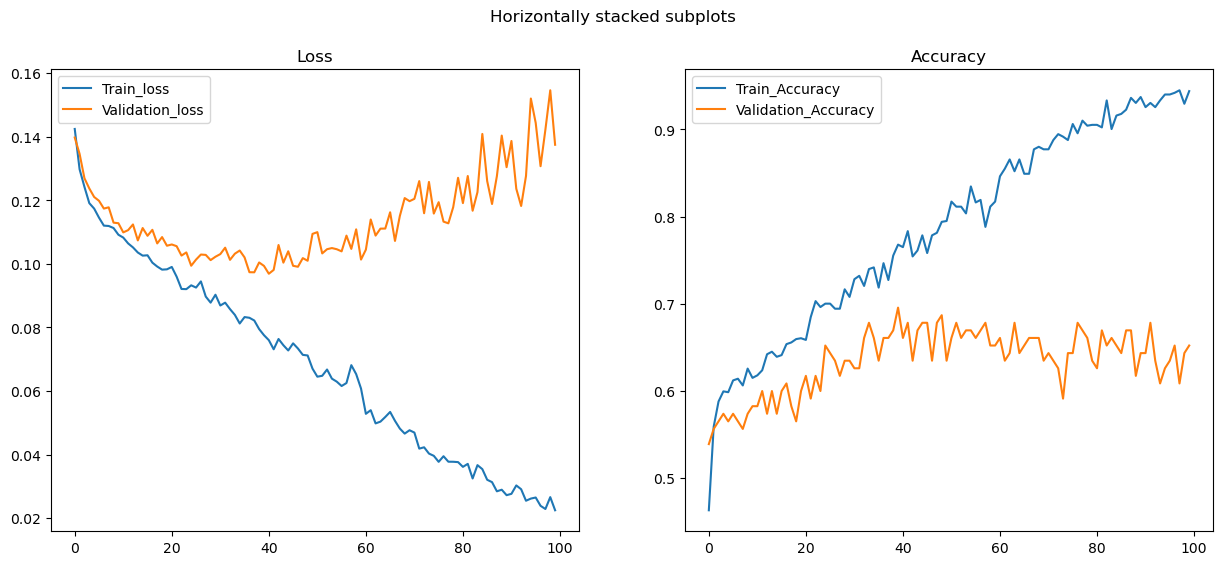

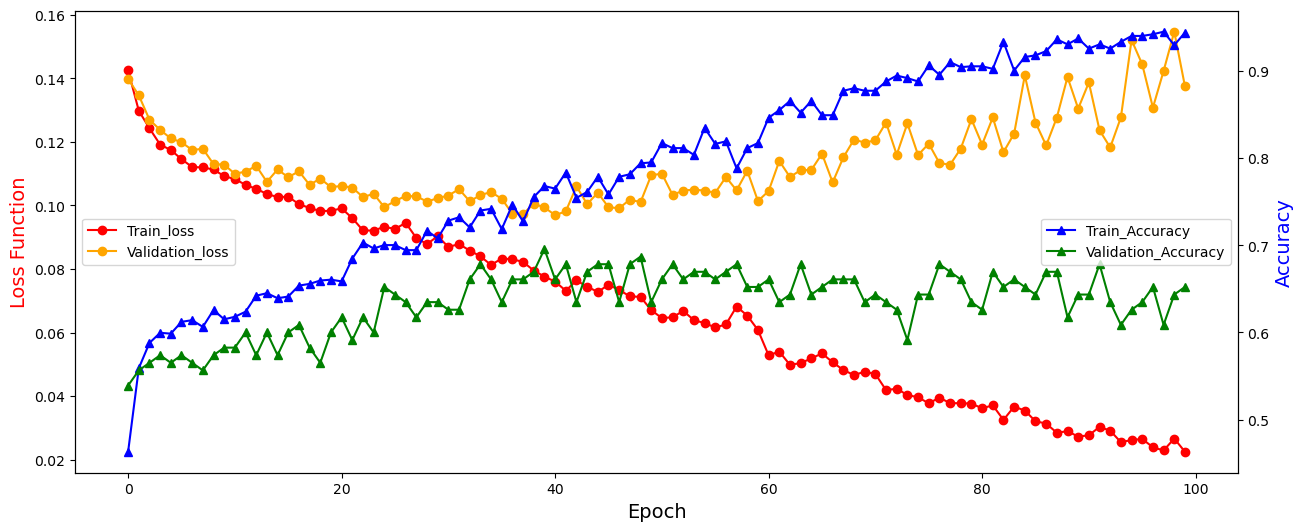

Current time: 88.701 minutes. Time expected till completion: 0.000 minutes
Finished training in: 88.705 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6956521739130435

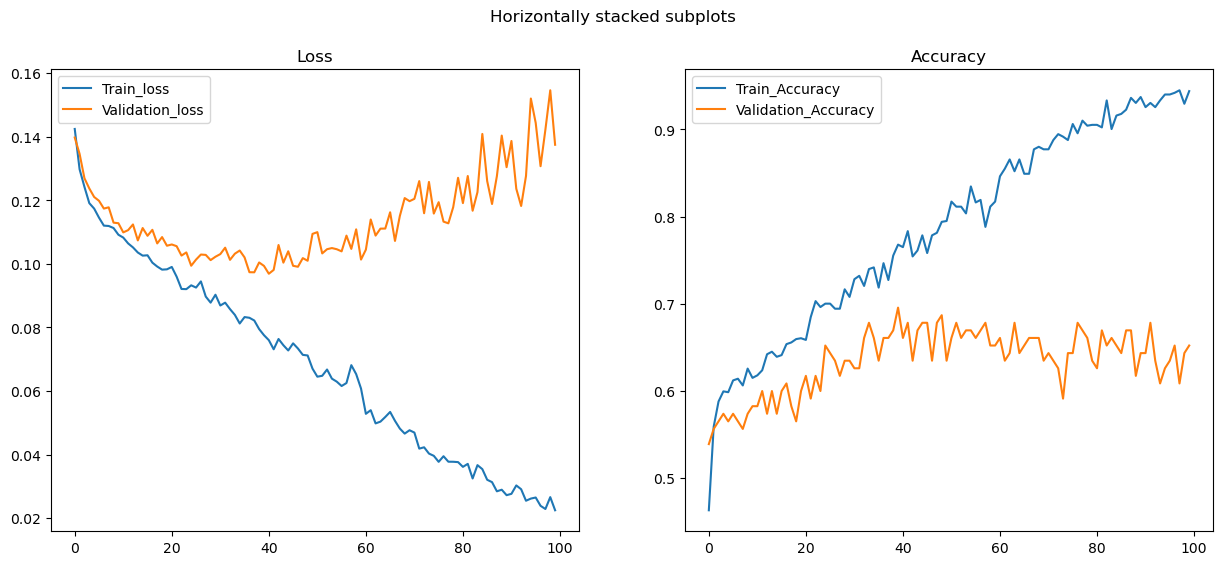

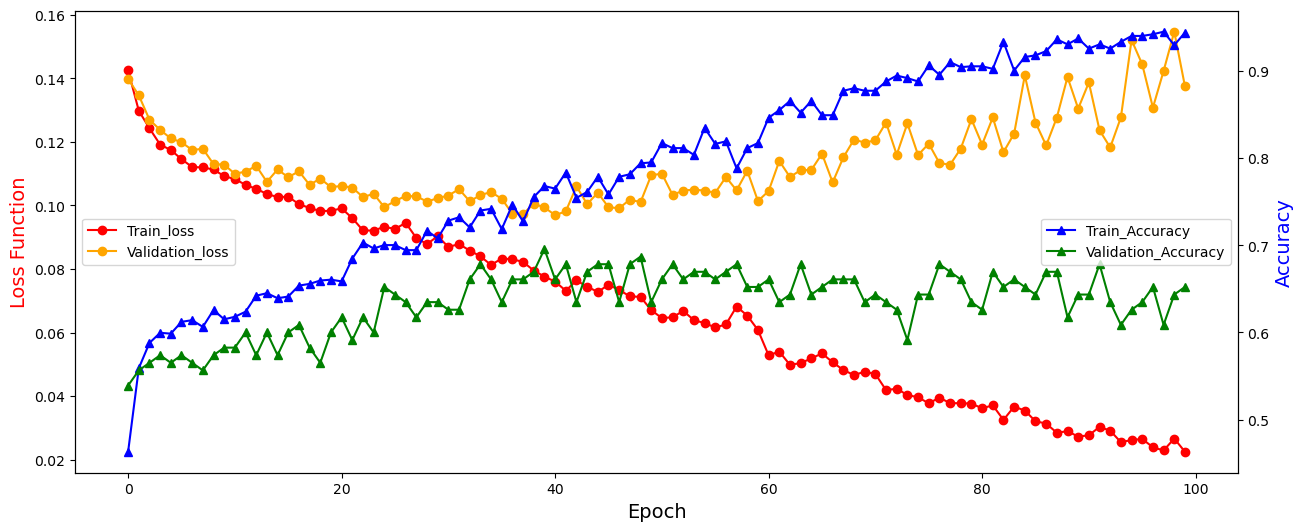

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:19<00:00,  6.65it/s]


Accuracy of the network on the 1034 Train instances: 98.93617021276596%


100%|██████████| 15/15 [00:02<00:00,  7.11it/s]

Accuracy of the network on the 115 Validation instances: 65.21739130434783%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:34<00:00, 10.89it/s]


(array([0, 1, 2]), array([166, 173,  41], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_GoogLeNet_prediction.csv")

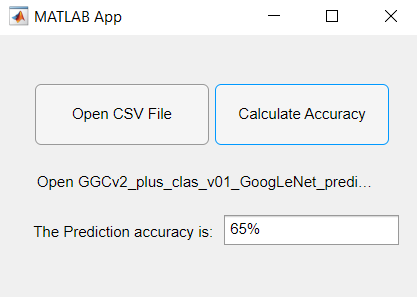

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:19<00:00,  6.53it/s]


Accuracy of the network on the 1034 Train instances: 82.20502901353966%


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]

Accuracy of the network on the 115 Validation instances: 69.56521739130434%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:10<00:00, 36.61it/s]


(array([0, 1, 2]), array([172, 165,  43], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_GoogLeNet_best_prediction.csv")

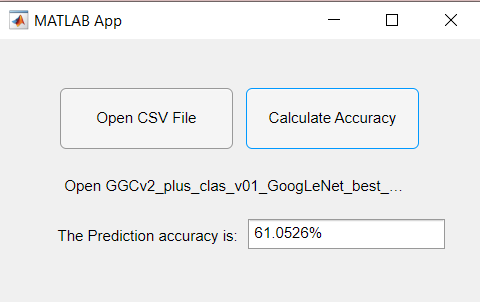